# Understanding Deepfakes with Keras

![DCGAN](DCGAN.png)

***Architecture guidelines for stable Deep Convolutional GANs***

* Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
* Use batchnorm in both the generator and the discriminator.
* Remove fully connected hidden layers for deeper architectures.
* Use ReLU activation in generator for all layers except for the output, which uses Tanh.
* Use LeakyReLU activation in the discriminator for all layers.

# Task 1: Importing Libraries and Helper Functions

Please note: If you haven't already, please install the required packages by executing the code cell below.

In [7]:
#!pip3 install tensorflow==2.1.0 pillow matplotlib
#!pip3 install git+https://github.com/am1tyadav/tfutils.git

In [18]:
%matplotlib notebook

import tensorflow as tf
import numpy as np
import os
#import tfutils
#import tfutils.datasets.mnist
#import tfutils.plotting
#import tfutils.keras


from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose, Reshape, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from PIL import Image

from dcGANUtils import *

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.2.0


# Task 2: Importing and Plotting the Data

In [19]:
(x_train, y_train), (x_test, y_test) =load_data(one_hot=False)

x_train = load_subset([0], x_train, y_train)
x_test = load_subset([0], x_test, y_test)

x = np.concatenate([x_train, x_test], axis=0)

<IPython.core.display.Javascript object>


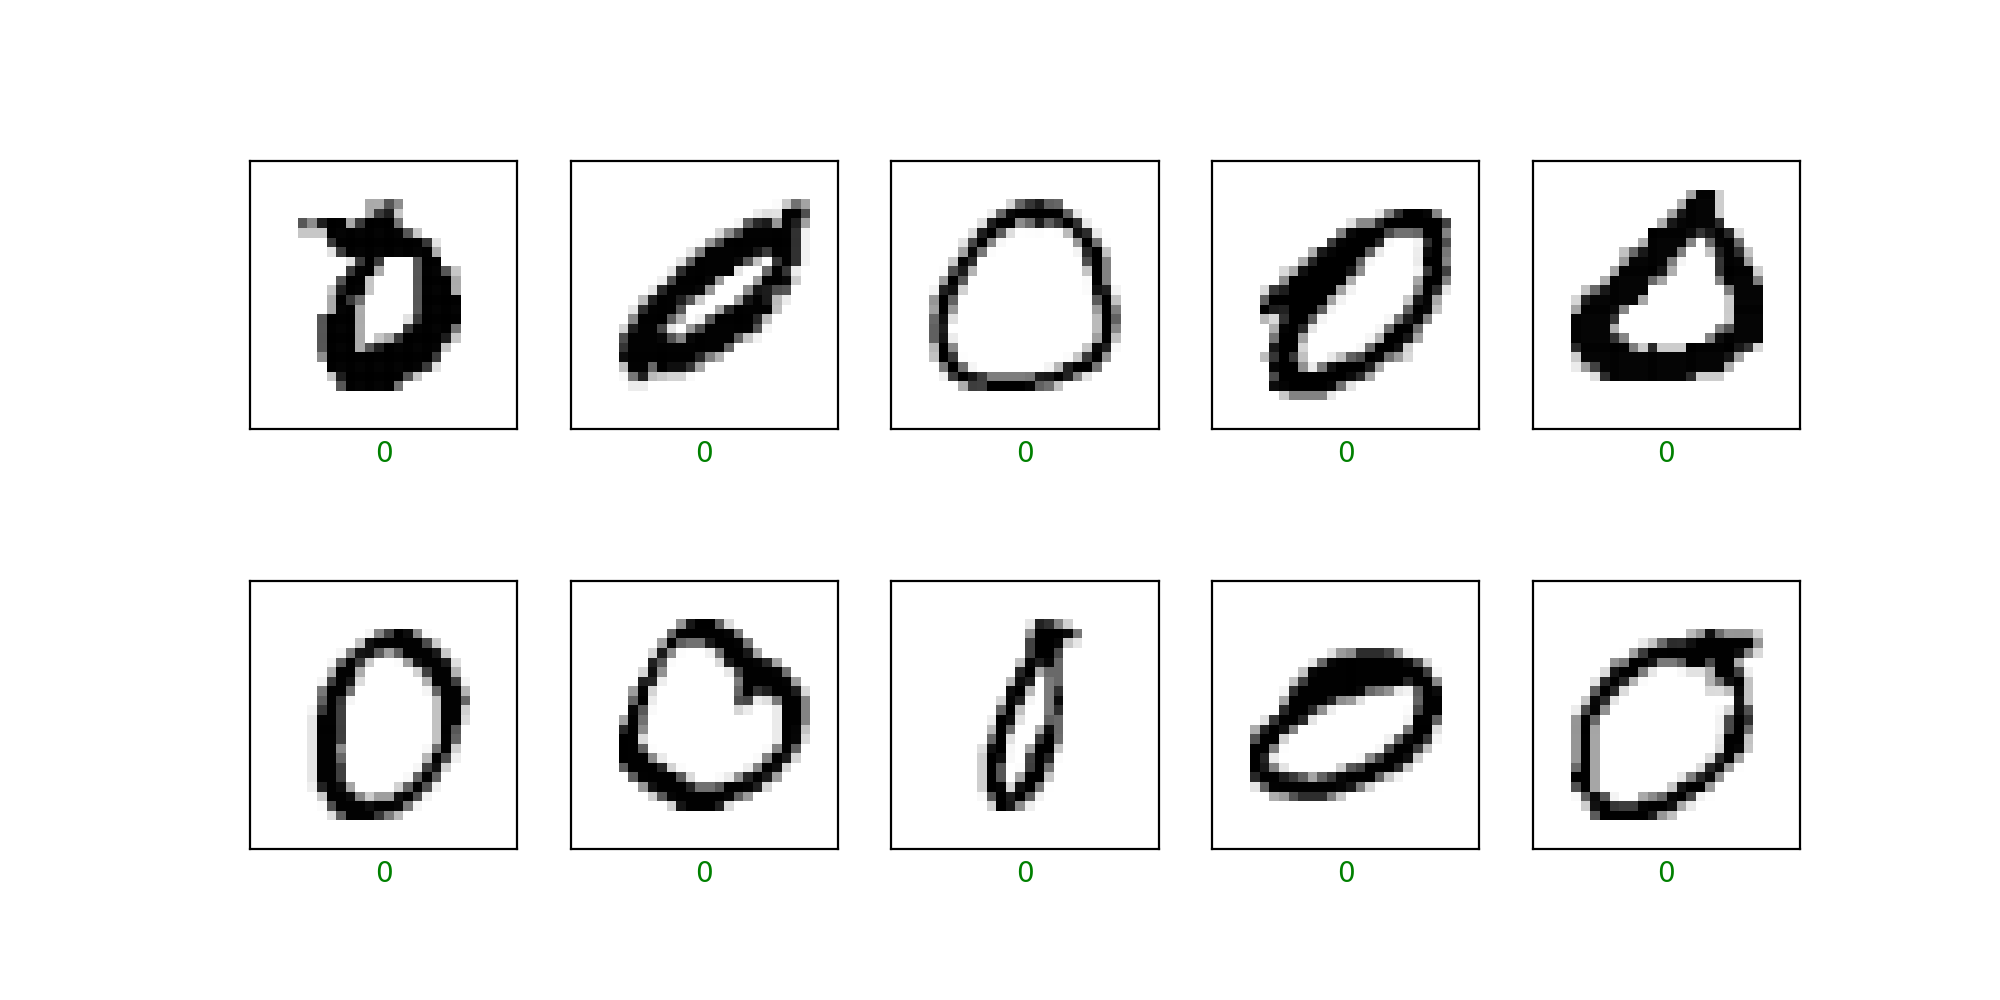

In [20]:
plot_ten_random_examples(plt, x, np.zeros((x.shape[0], 1))).show()

# Task 3: Discriminator

![Artist and Critic](artist_critic.png)

In [21]:
size = 28
noise_dim = 1

discriminator = Sequential([
    Conv2D(64, 3, strides=2, input_shape=(28, 28, 1)),
    LeakyReLU(),
    BatchNormalization(),
    
    Conv2D(128, 5, strides=2),
    LeakyReLU(),
    BatchNormalization(),
    
    Conv2D(256, 5, strides=2),
    LeakyReLU(),
    BatchNormalization(),
    
    Flatten(),
    Dense(1, activation='sigmoid')
])

opt = tf.keras.optimizers.Adam(lr=2e-4, beta_1=0.5)

discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 13, 13, 64)        640       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 13, 13, 64)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 5, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 5, 5, 128)         0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 5, 5, 128)         512       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 1, 256)        

# Task 4: Generator

In [22]:
generator = Sequential([
    Dense(256, activation='relu', input_shape=(noise_dim,)),
    Reshape((1, 1, 256)),
    
    Conv2DTranspose(256, 5, activation='relu'),
    BatchNormalization(),
    Conv2DTranspose(128, 5, activation='relu'),
    BatchNormalization(),

    Conv2DTranspose(64, 5, strides=2, activation='relu'),
    BatchNormalization(),
    Conv2DTranspose(32, 5, activation='relu'),
    BatchNormalization(),

    Conv2DTranspose(1, 4, activation='sigmoid')

])

generator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               512       
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 1, 256)         0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 5, 5, 256)         1638656   
_________________________________________________________________
batch_normalization_10 (Batc (None, 5, 5, 256)         1024      
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 9, 9, 128)         819328    
_________________________________________________________________
batch_normalization_11 (Batc (None, 9, 9, 128)         512       
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 21, 21, 64)       

<IPython.core.display.Javascript object>


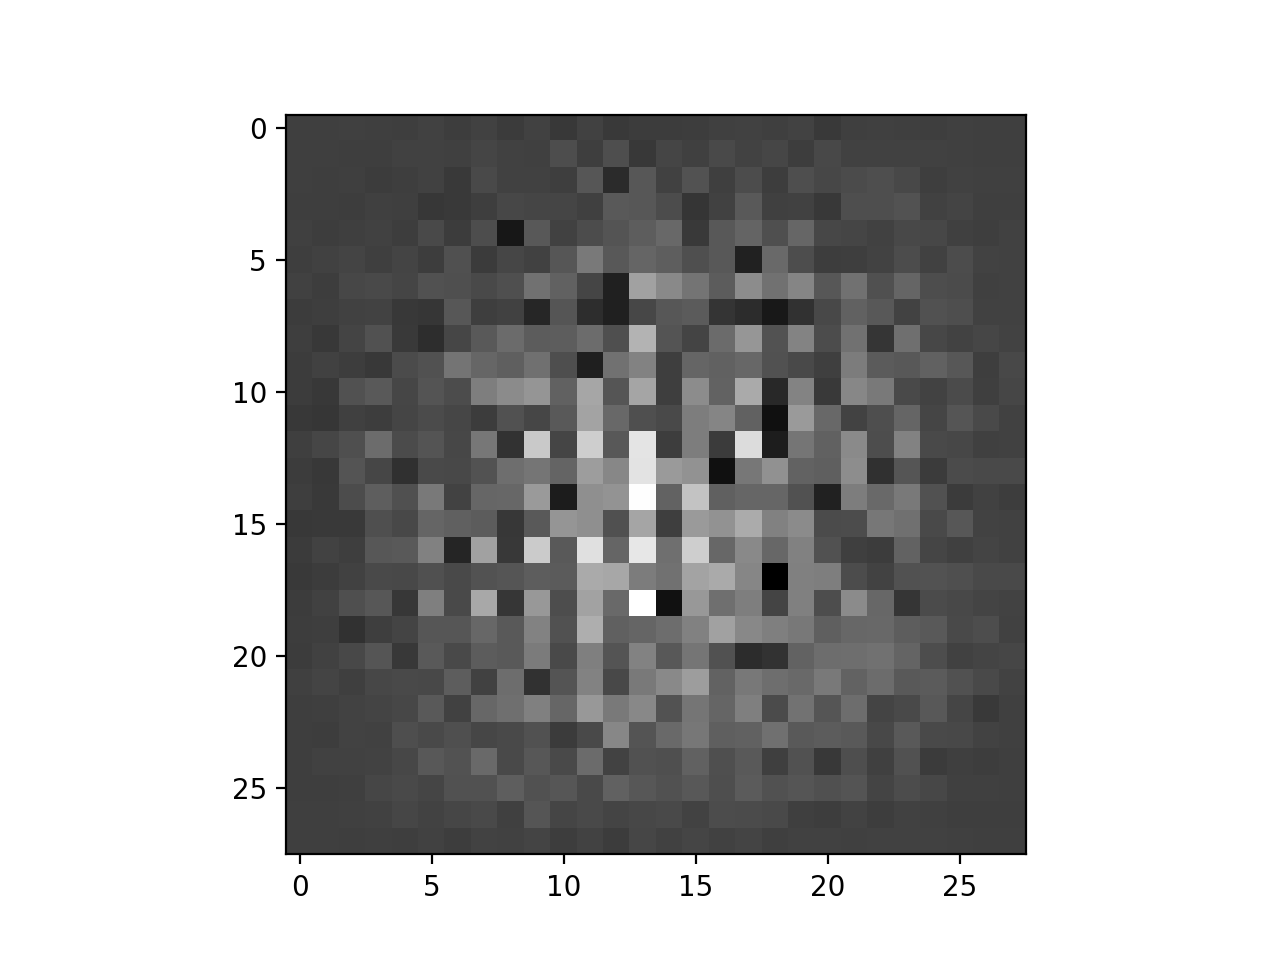

In [23]:
noise = np.random.randn(1, noise_dim)
gen_image = generator.predict(noise)[0]

plt.figure()
plt.imshow(np.reshape(gen_image, (28, 28)), cmap='binary');

# Task 5: Generative Adversarial Network (GAN)

In [24]:
input_layer = tf.keras.layers.Input(shape=(noise_dim,))
gen_out = generator(input_layer)
disc_out = discriminator(gen_out)

gan = Model(
    input_layer,
    disc_out
)

discriminator.trainable = False
gan.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
gan.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 28, 28, 1)         2717025   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1027073   
Total params: 3,744,098
Trainable params: 2,716,065
Non-trainable params: 1,028,033
_________________________________________________________________


# Tasks 6 and 7: Training the GAN

In [26]:
class DynamicPlot:
    def __init__(self, plt, rows, cols, figsize):
        self.rows = rows
        self.cols = cols

        self.plt = plt

        self.fig = self.plt.figure(figsize=figsize)
        self.plt.ion()

    def draw_fig(self):
        self.fig.show()
        self.fig.canvas.draw()

    def start_of_epoch(self, epoch):
        self.ax = self.plt.subplot(self.rows, self.cols, 1 + epoch)

    def end_of_epoch(self, image, cmap, xlabel, ylabel):
        self.ax.imshow(image, cmap=cmap)
        self.ax.set_xlabel(xlabel)
        self.ax.set_ylabel(ylabel)
        self.ax.set_xticks([])
        self.ax.set_yticks([])
        self.draw_fig()

Steps per epoch= 107


<IPython.core.display.Javascript object>


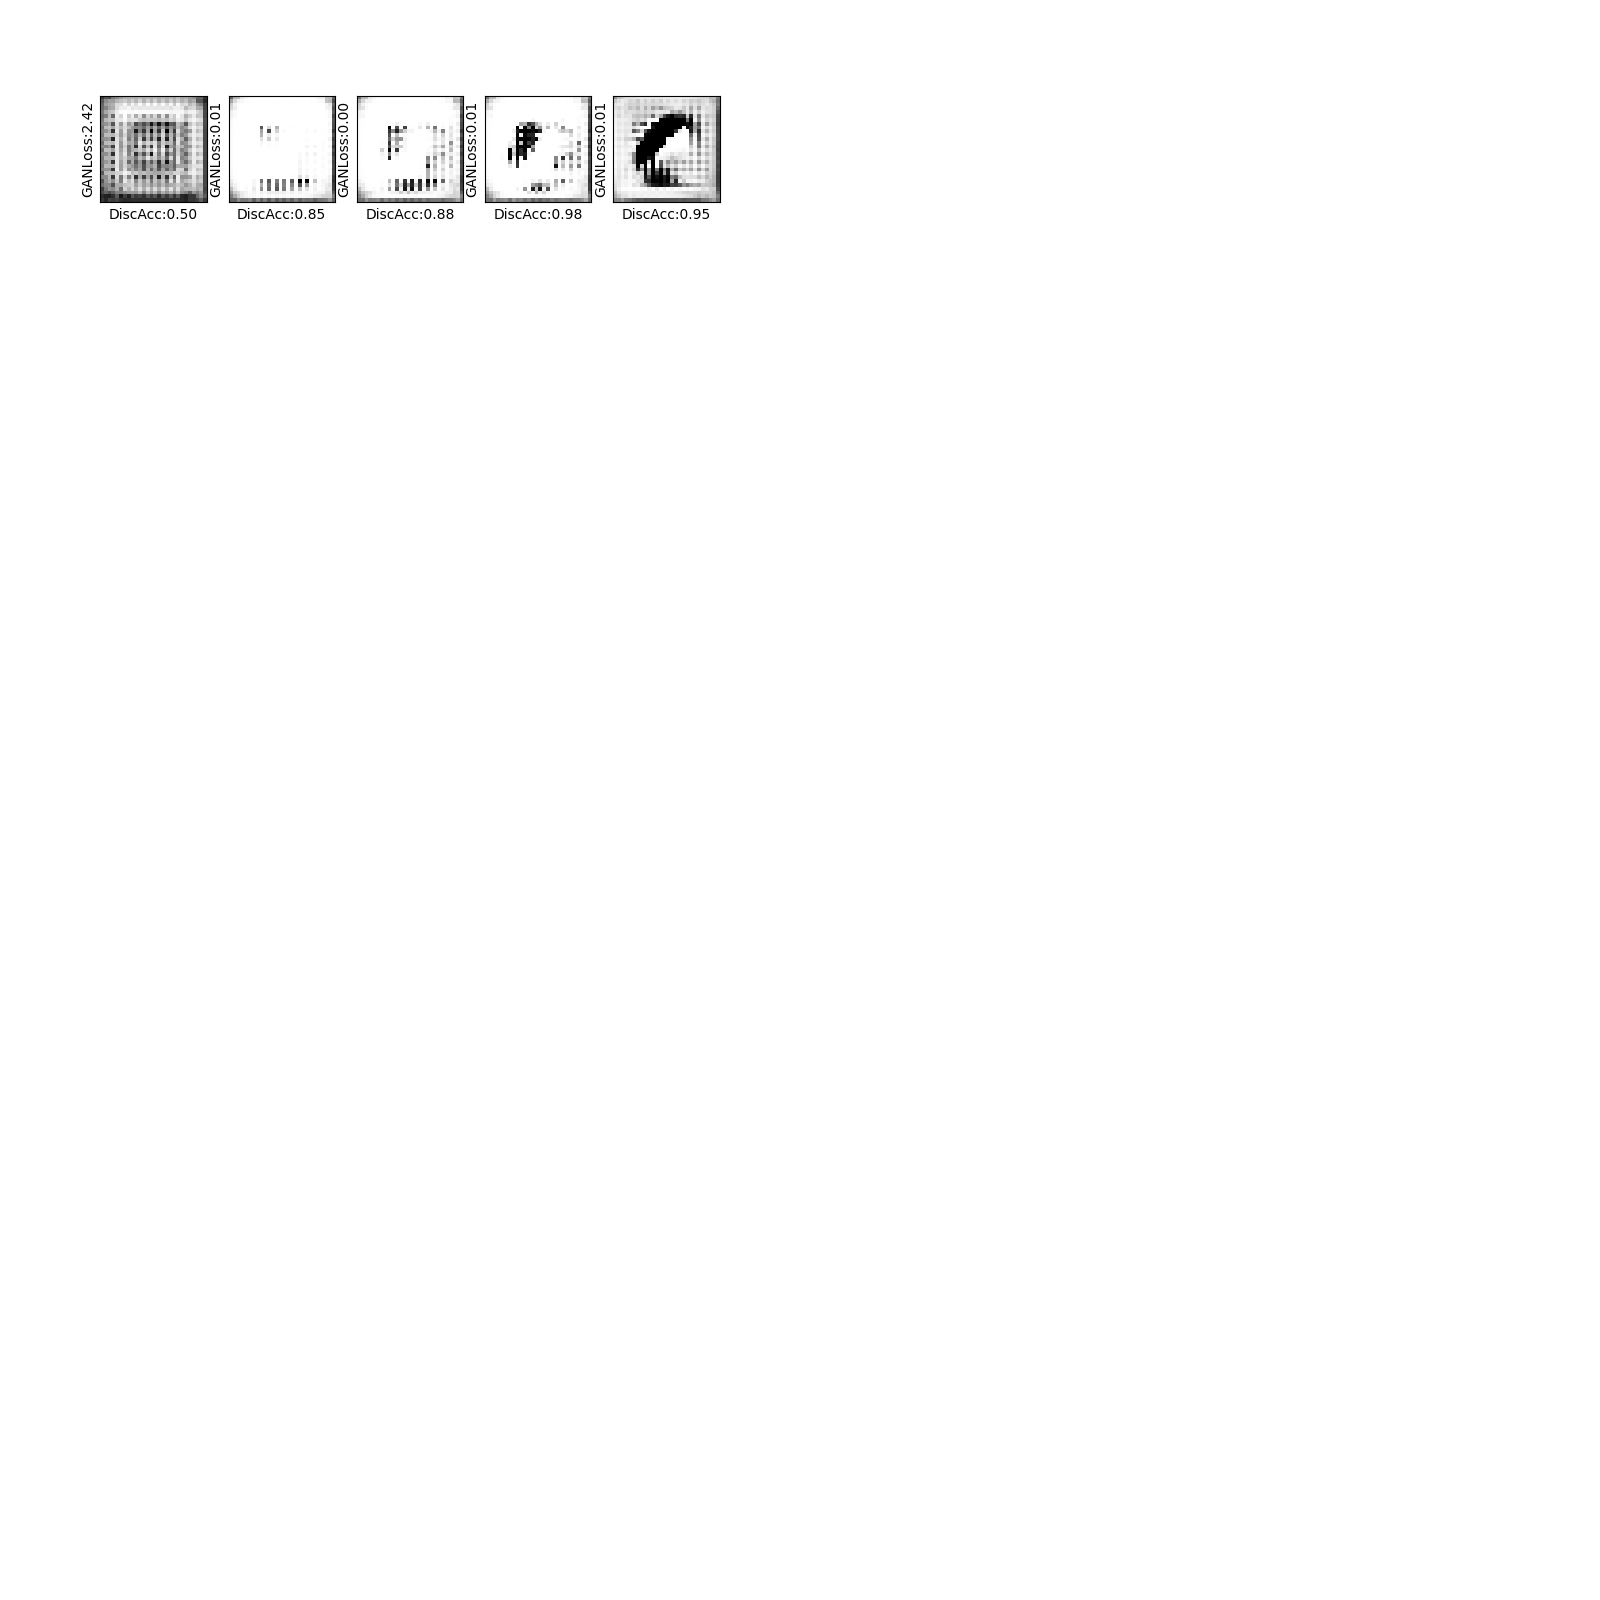

In [ ]:
%%time

epochs = 25
batch_size = 128
steps_per_epoch = int(2 * x.shape[0]/batch_size)

print('Steps per epoch=', steps_per_epoch)

dp = DynamicPlot(plt, 5, 5, (8, 8))

for e in range(0, epochs):
    
    dp.start_of_epoch(e)
    
    for step in range(0, steps_per_epoch):
        true_examples = x[int(batch_size/2)*step: int(batch_size/2)*(step + 1)]
        true_examples = np.reshape(true_examples, (true_examples.shape[0], 28, 28, 1))

        noise = np.random.randn(int(batch_size/2), noise_dim)
        generated_examples = generator.predict(noise)

        x_batch = np.concatenate([generated_examples, true_examples], axis=0)
        y_batch = np.array([0] * int(batch_size/2) + [1] * int(batch_size/2))

        indices = np.random.choice(range(batch_size), batch_size, replace=False)
        x_batch = x_batch[indices]
        y_batch = y_batch[indices]

        # train the discriminator
        discriminator.trainable = True
        discriminator.train_on_batch(x_batch, y_batch)
        discriminator.trainable = False

        # train the generator
        loss, _ = gan.train_on_batch(noise, np.ones((int(batch_size/2), 1)))

        _, acc = discriminator.evaluate(x_batch, y_batch, verbose=False)

    noise = np.random.randn(1, noise_dim)
    generated_example = generator.predict(noise)[0]
    
    dp.end_of_epoch(np.reshape(generated_example, (28, 28)), 'binary',
                   'DiscAcc:{:.2f}'.format(acc), 'GANLoss:{:.2f}'.format(loss))